##### Final Project on Adverse Drug Events for Asian American Demographic. It is important to note that the training data and the test data being predicted on, is built off inferred features from the FAERS dataset and NHANES dataset, and includes a synthetic target. Thus this prediction is more indicative of the dataset's internal logic, rather than confirming any external validity in the field of ADEs.

In [336]:
#Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.base import BaseEstimator, ClassifierMixin

In [337]:
#Load data
with open('../config.json', 'r') as config_file:
    config = json.load(config_file)

training_data = config.get('training')
training_data = pd.read_csv(training_data)
test_data = config.get('enriched_processed')
test_data = pd.read_csv(test_data)
training_data.head()

,age_group,polypharmacy_risk,confidence,health_score_normalized,ade_likelihood_normalized,avg_drug_risk_normalized,weighted_ade_likelihood,weighted_avg_drug_risk,synthetic_risk
0,Elderly,Low,1996,0.163498,0.293006,0.124957,0.330439,0.088249,Low Risk
1,Middle Aged,Low,2844,0.244147,0.010268,0.107478,0.199238,0.223004,Low Risk
2,Child,Low,1460,0.124695,0.000000,0.000000,0.000000,0.137798,Low Risk
3,Middle Aged,Low,2844,0.199744,0.233489,0.303742,0.199238,0.413507,Low Risk
4,Child,Low,1460,0.001501,0.000000,0.073805,0.000000,0.035557,Low Risk


In [338]:
# Define feature columns and target
feature_columns = [
    'confidence',
    'health_score_normalized',
    'ade_likelihood_normalized',
    'avg_drug_risk_normalized',
    'weighted_ade_likelihood',
    'weighted_avg_drug_risk'
]

#Features + Target
X = training_data[feature_columns]
y = training_data['synthetic_risk']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Check label encoding mapping
print(f"Label encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

Label encoding: {'High Risk': 0, 'Low Risk': 1, 'Moderate Risk': 2}


In [339]:
# Define logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation
cv_scores = cross_val_score(logistic_model, X_scaled, y_encoded, cv=kf, scoring='accuracy')

# Display results
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")

Cross-validation accuracy scores: [0.98561151 0.96402878 0.95683453 0.97826087 0.97101449]
Mean CV accuracy: 0.9712


This seems to be overfitting possibly due to using an oversampled dataset for training purposes.

In [340]:
# Train the model on the entire dataset
logistic_model.fit(X_scaled, y_encoded)

# Predict on the training data
y_pred = logistic_model.predict(X_scaled)

# Decode predictions back to categories
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Classification report
print("Classification Report on Training Data:")
print(classification_report(y, y_pred_decoded))

# Confusion matrix
conf_matrix = confusion_matrix(y, y_pred_decoded)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report on Training Data:
               precision    recall  f1-score   support

    High Risk       0.94      1.00      0.97       186
     Low Risk       0.99      0.98      0.99       223
Moderate Risk       0.99      0.95      0.97       284

     accuracy                           0.97       693
    macro avg       0.97      0.98      0.97       693
 weighted avg       0.97      0.97      0.97       693

Confusion Matrix:
[[186   0   0]
 [  0 219   4]
 [ 12   2 270]]


Classification Report on Test Data:
               precision    recall  f1-score   support

    High Risk       0.50      1.00      0.67         1
     Low Risk       0.98      0.93      0.95        44
Moderate Risk       0.99      0.99      0.99       231

     accuracy                           0.98       276
    macro avg       0.82      0.97      0.87       276
 weighted avg       0.98      0.98      0.98       276

Confusion Matrix on Test Data:
[[  1   0   0]
 [  0  41   3]
 [  1   1 229]]


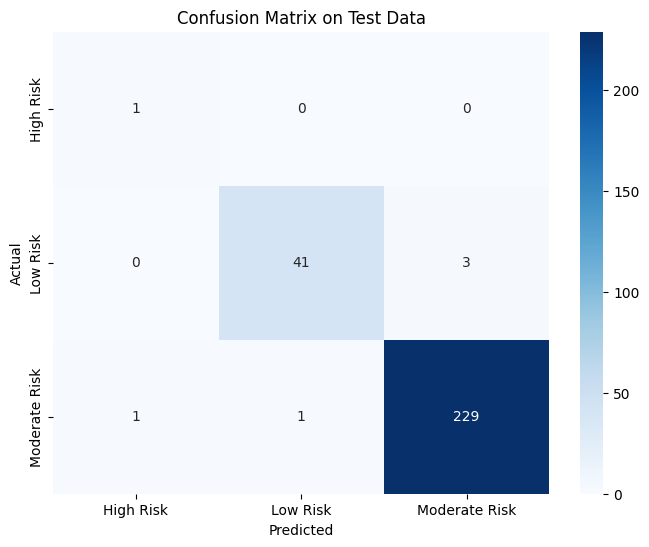

In [341]:
# Prepare test features and target
X_test = test_data[feature_columns]  # Exclude the target column
y_test = test_data['synthetic_risk']

# Encode the target variable
y_test_encoded = label_encoder.transform(y_test)  # Ensure consistent encoding

# Scale the test features
X_test_scaled = scaler.transform(X_test)

# Predict on the test set
y_test_pred = logistic_model.predict(X_test_scaled)

# Decode predictions back to categories
y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)

# Evaluate performance
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred_decoded))

# Confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred_decoded)
print("Confusion Matrix on Test Data:")
print(conf_matrix_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix on Test Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy: Achieves 98% overall accuracy, indicating excellent performance.
Class-Level Performance:
High Risk: Perfect recall (1.00) but low precision (0.50); limited by only 1 sample.
Low Risk: Near perfect precision (.98), recall at 0.93; a few misclassified as "Moderate Risk"
Moderate Risk: Nearly perfect precision and recall; the dominant class.

The sole "High Risk" was correctly classified.

Stratified k-Fold Cross-Validation Results:

Fold 1 Classification Report:
               precision    recall  f1-score   support

    High Risk       1.00      1.00      1.00        37
     Low Risk       1.00      0.96      0.98        45
Moderate Risk       0.97      1.00      0.98        57

     accuracy                           0.99       139
    macro avg       0.99      0.99      0.99       139
 weighted avg       0.99      0.99      0.99       139



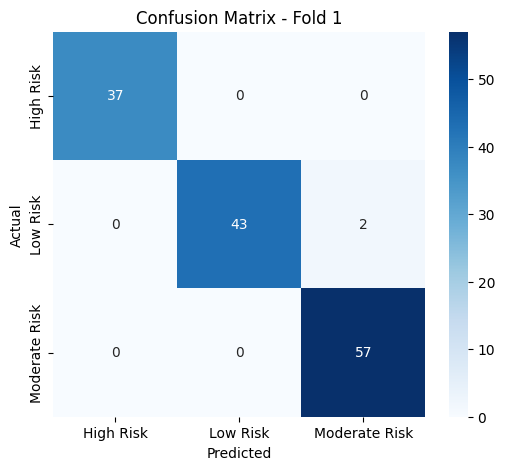

Fold 2 Classification Report:
               precision    recall  f1-score   support

    High Risk       0.95      1.00      0.97        37
     Low Risk       0.94      1.00      0.97        45
Moderate Risk       1.00      0.91      0.95        57

     accuracy                           0.96       139
    macro avg       0.96      0.97      0.97       139
 weighted avg       0.97      0.96      0.96       139



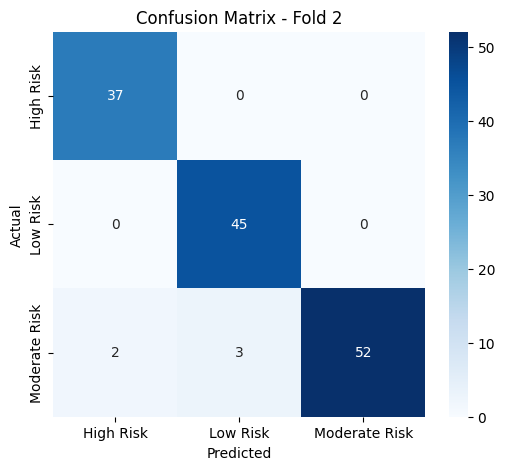

Fold 3 Classification Report:
               precision    recall  f1-score   support

    High Risk       0.93      1.00      0.96        38
     Low Risk       1.00      1.00      1.00        45
Moderate Risk       1.00      0.95      0.97        56

     accuracy                           0.98       139
    macro avg       0.98      0.98      0.98       139
 weighted avg       0.98      0.98      0.98       139



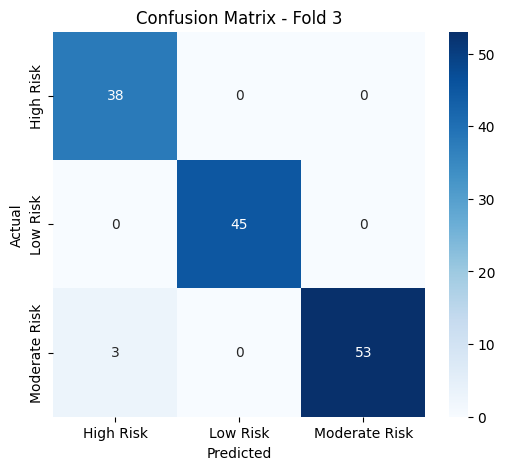

Fold 4 Classification Report:
               precision    recall  f1-score   support

    High Risk       0.90      1.00      0.95        37
     Low Risk       1.00      1.00      1.00        44
Moderate Risk       1.00      0.93      0.96        57

     accuracy                           0.97       138
    macro avg       0.97      0.98      0.97       138
 weighted avg       0.97      0.97      0.97       138



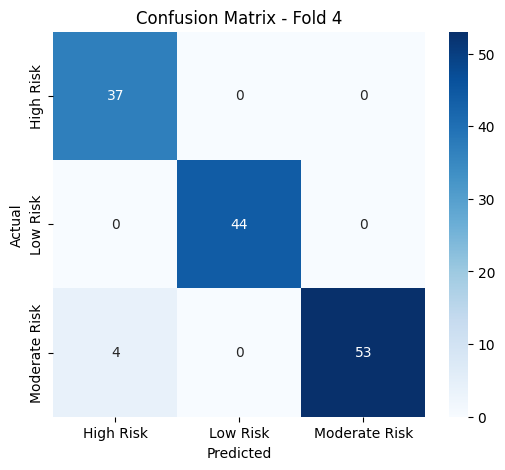

Fold 5 Classification Report:
               precision    recall  f1-score   support

    High Risk       0.90      1.00      0.95        37
     Low Risk       0.98      0.98      0.98        44
Moderate Risk       0.98      0.91      0.95        57

     accuracy                           0.96       138
    macro avg       0.95      0.96      0.96       138
 weighted avg       0.96      0.96      0.96       138



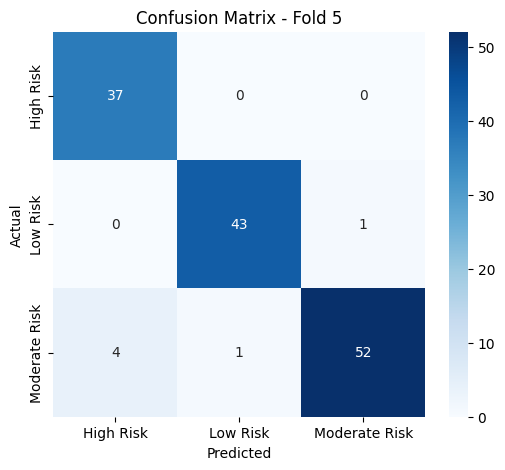


=== Final Cross-Validation Results ===
Macro-Averaged F1 Score: 0.972
Weighted-Averaged F1 Score: 0.971
Average Accuracy: 0.971


In [342]:
#Stratified K-Fold Cross Validation
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(training_data['synthetic_risk'])

# Define features and target
feature_columns = [
    'confidence',
    'health_score_normalized',
    'ade_likelihood_normalized',
    'avg_drug_risk_normalized',
    'weighted_ade_likelihood',
    'weighted_avg_drug_risk',
]
X = training_data[feature_columns].values
y = y_encoded

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified k-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []

print("Stratified k-Fold Cross-Validation Results:\n")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled, y), 1):
    # Split data into training and validation sets
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Train Logistic Regression model
    logistic_model = LogisticRegression(random_state=42, max_iter=500)
    logistic_model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_val_pred = logistic_model.predict(X_val)
    
    # Decode predictions and actuals for reporting
    y_val_pred_decoded = label_encoder.inverse_transform(y_val_pred)
    y_val_decoded = label_encoder.inverse_transform(y_val)
    
    # Evaluate performance
    report = classification_report(y_val_decoded, y_val_pred_decoded, output_dict=True)
    conf_matrix = confusion_matrix(y_val_decoded, y_val_pred_decoded)
    fold_metrics.append(report)
    
    # Print classification report for each fold
    print(f"Fold {fold} Classification Report:")
    print(classification_report(y_val_decoded, y_val_pred_decoded))
    
    # Plot confusion matrix for each fold
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Aggregate metrics across all folds
macro_avg_f1 = np.mean([fold['macro avg']['f1-score'] for fold in fold_metrics])
weighted_avg_f1 = np.mean([fold['weighted avg']['f1-score'] for fold in fold_metrics])
accuracy = np.mean([fold['accuracy'] for fold in fold_metrics])

print("\n=== Final Cross-Validation Results ===")
print(f"Macro-Averaged F1 Score: {macro_avg_f1:.3f}")
print(f"Weighted-Averaged F1 Score: {weighted_avg_f1:.3f}")
print(f"Average Accuracy: {accuracy:.3f}")

Macro-Averaged F1 Score (0.972): The model performs well across all classes, even smaller ones, by giving each class equal importance.
Weighted-Averaged F1 Score (0.971): The model performs well overall, accounting for how often each class appears.
Accuracy (0.971): The model correctly predicts about 97% of the data during cross-validation.
Overfitting Risk:

The model seems to overfit to the oversampled data with added noise.

Cross-Validation Scores: [0.61870504 0.94964029 0.98561151 1.         0.99275362]
Mean CV Score: 0.9093420915441559
Standard Deviation of CV Scores: 0.14634698970616242


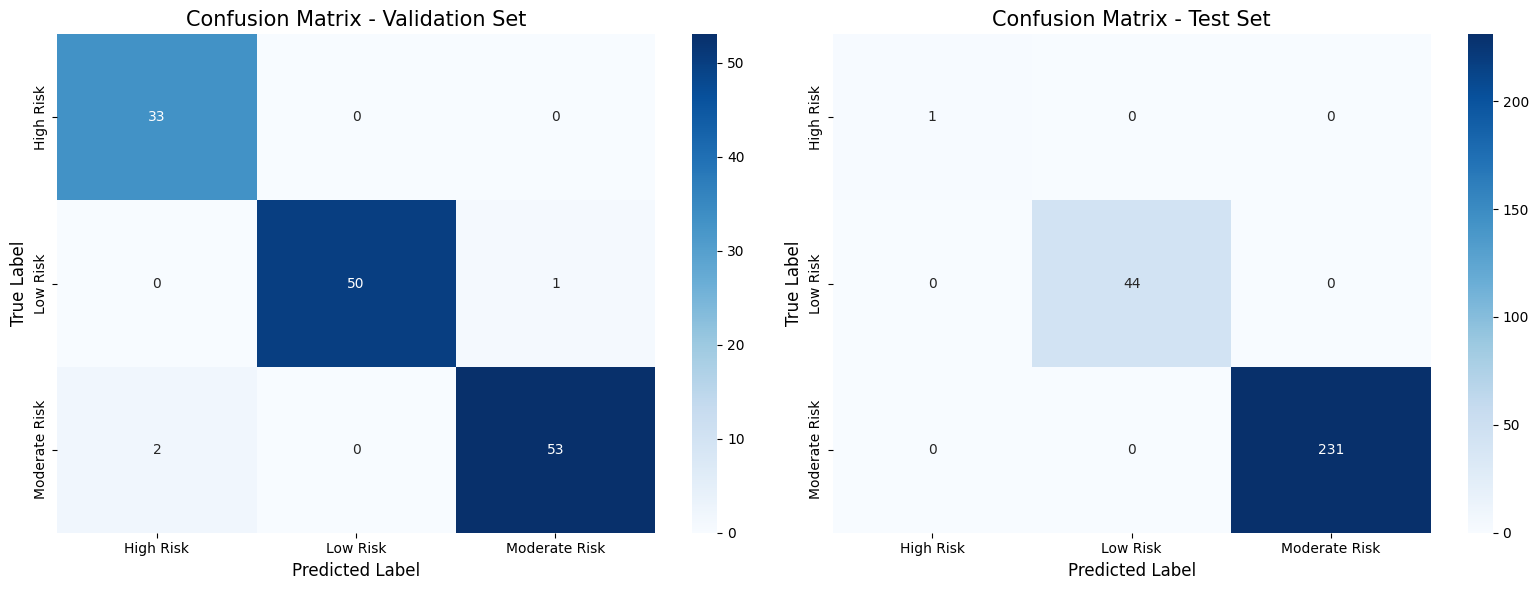


Validation Set Confusion Matrix:
[[33  0  0]
 [ 0 50  1]
 [ 2  0 53]]

Test Set Confusion Matrix:
[[  1   0   0]
 [  0  44   0]
 [  0   0 231]]

Validation Set Classification Report:
               precision    recall  f1-score   support

    High Risk       0.94      1.00      0.97        33
     Low Risk       1.00      0.98      0.99        51
Moderate Risk       0.98      0.96      0.97        55

     accuracy                           0.98       139
    macro avg       0.97      0.98      0.98       139
 weighted avg       0.98      0.98      0.98       139


Test Set Classification Report:
               precision    recall  f1-score   support

    High Risk       1.00      1.00      1.00         1
     Low Risk       1.00      1.00      1.00        44
Moderate Risk       1.00      1.00      1.00       231

     accuracy                           1.00       276
    macro avg       1.00      1.00      1.00       276
 weighted avg       1.00      1.00      1.00       276



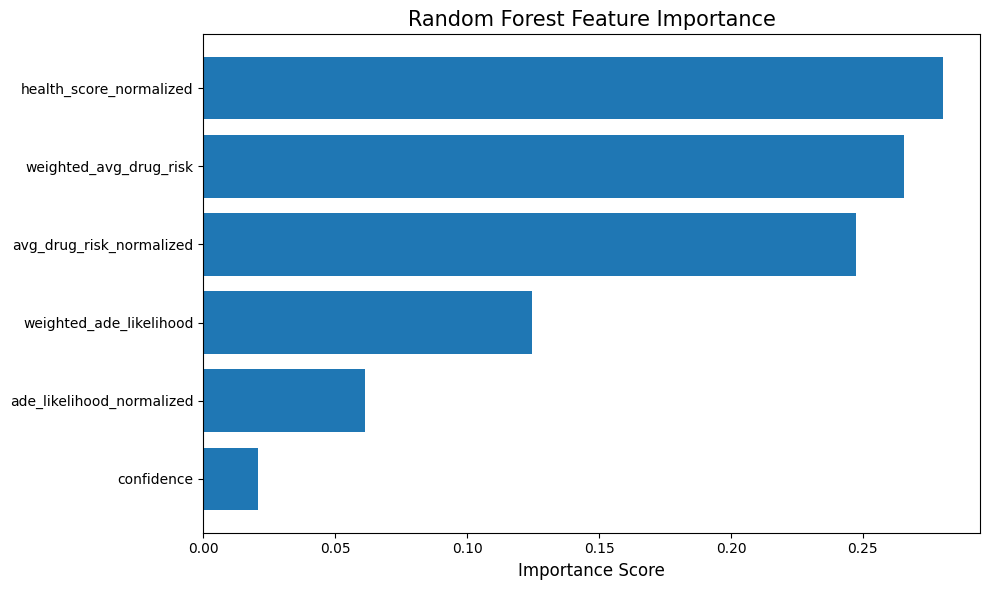

In [348]:
#Advanced Model (Random Forest)
#Training data
X = training_data[feature_columns]
y = training_data['synthetic_risk']

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

# Initialize and train Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=None,    # Full tree growth
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model
rf_classifier.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(
    rf_classifier, 
    X_scaled, 
    y_encoded, 
    cv=5, 
    scoring='accuracy'
)

# Prints the cross-validation scores, mean, and standard deviation
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

# Predictions on validation set
y_val_pred = rf_classifier.predict(X_val)

# Test Set Evaluation
X_test = test_data[feature_columns]
y_test = test_data['synthetic_risk']
y_test_encoded = label_encoder.transform(y_test)

# Scale test features using training scaler
X_test_scaled = scaler.transform(X_test)

# Predict on test set
y_test_pred = rf_classifier.predict(X_test_scaled)


def plot_confusion_matrices(y_val, y_val_pred, y_test, y_test_pred, classes):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Validation Set Confusion Matrix
    conf_matrix_val = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, 
                yticklabels=classes,
                ax=ax1)
    ax1.set_title('Confusion Matrix - Validation Set', fontsize=15)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.set_ylabel('True Label', fontsize=12)
    
    # Test Set Confusion Matrix
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, 
                yticklabels=classes,
                ax=ax2)
    ax2.set_title('Confusion Matrix - Test Set', fontsize=15)
    ax2.set_xlabel('Predicted Label', fontsize=12)
    ax2.set_ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Return confusion matrices for additional analysis if needed
    return conf_matrix_val, conf_matrix_test

# Plot Confusion Matrices
plot_confusion_matrices(
    y_val, 
    y_val_pred, 
    y_test_encoded, 
    y_test_pred, 
    label_encoder.classes_
)


print("\nValidation Set Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

print("\nTest Set Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_test_pred))

# Classification Reports
print("\nValidation Set Classification Report:")
print(classification_report(
    y_val, 
    y_val_pred, 
    target_names=label_encoder.classes_
))

print("\nTest Set Classification Report:")
print(classification_report(
    y_test_encoded, 
    y_test_pred, 
    target_names=label_encoder.classes_
))

def plot_feature_importance(rf_classifier, feature_columns):
    plt.figure(figsize=(10, 6))
    feature_importance = rf_classifier.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=True)
    
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.title('Random Forest Feature Importance', fontsize=15)
    plt.xlabel('Importance Score', fontsize=12)
    plt.tight_layout()
    plt.show()
    
plot_feature_importance(rf_classifier, feature_columns)




Validation Set: 
Mean Cross Validation was about 90.9% accurate, but std is 14.63% indicating high variability on different subsets of the data
Classification Report: Overall accuracy was about 98%, with low risk overall performing the best.

Test Set:
100% accuracy, perfect precision, recall, f1-score

Confusion matrix: 
2 misclassified for high risk and 1 misclassfied for moderate risk. 